In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/AnyoneAI/Final_Project/e_commerce_categorization')

In [3]:
# We import the needed packages.
import pandas as pd
import pickle
import nltk
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import RandomizedSearchCV
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.util import ngrams
import numpy as np

In [ ]:
# We need to get the y output we defined in the EDA in order to work here new models.
directorio = 'dataset/categorias_buleanas.csv'
y = pd.read_csv(directorio)
y

,others,appliance,cell phone,cell phone accessory,computer tablets,video games,connected home housewares,small kitchen appliances,cameras camcorder,audio,...,nintendo ds games,case,tv,security cameras surveillance,build dishwasher,laptop battery,household essential,iphone case,cooktop,coffee maker
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51640,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
51641,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51642,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51643,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1]:
# Now we need to import the models defined before for the descriptions.
filepath = 'modelos/best_moc.pkl'

In [4]:
with open(filepath, 'rb') as file:
    model_moc_pkl = pickle.load(file)

In [ ]:
from src import text_normalizer
stop_words = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
import gensim.downloader
pretrained_w2v_model = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
def normalizacion(oracion):
    oracion_normalizada = text_normalizer.normalize_corpus(oracion, stopwords=stop_words, text_lemmatization=True)
    return oracion_normalizada

def generate_ngrams(tokens, n):
    '''Creates ngrams groups of n tokens together'''
    if n == 1:
        return tokens
    else:
        return [' '.join(ngram) for ngram in ngrams(tokens, n)]

def toktok(oraciones, ninit=1, nfin=1):
    '''
    oraciones: List of sentences to tokenize.
    ninit: Minimun amount of ngrams to get from tokens.
    nfin: Maximun amount of ngrams to get from tokens.
    '''

    tokenizer = ToktokTokenizer()

    oraciones_tokenizadas_ngramas = []

    for oracion in oraciones:
        ngram_tokens = [generate_ngrams(tokenizer.tokenize(oracion), n) for n in range(ninit, nfin+1)]
        ngram_tokens_flattened = [token for ngram in ngram_tokens for token in ngram]
        oraciones_tokenizadas_ngramas.append(ngram_tokens_flattened)

    return oraciones_tokenizadas_ngramas

def vectorizer_pretrained(corpus, model, num_features: int=100):
    '''
    Receives the description tokenised, it converts each tocken to a vector.
    Then creates a mean vector of all the vectors that represents each token.
    The result vector is returned.
    The default dimensionality of the vector is 100 but it can be changed.
    '''
    corpus_size = len(corpus)
    corpus_vectors = np.zeros((corpus_size, num_features), dtype=np.float32)

    for i, document in enumerate(corpus):
        word_count = 0
        doc_vector = np.zeros(num_features, dtype=np.float32)

        for word in document:
            if word in model:
                doc_vector += model.word_vec(word)
                word_count+=1

        if word_count > 0:
            doc_vector /= word_count

        corpus_vectors[i] = doc_vector

    return corpus_vectors


In [ ]:
# We read the products descriptions file we've saved before.
products_descri_df = pd.read_csv('dataset/prod_descri_normalized.csv')
products_descri_df.head()

,Skus,Descriptions,Char Count,Word Count,Sentence Count,Hashtag Count,@ Count
0,43900,compatible select electronic device aaa size d...,95,12,1,0,0
1,48530,long last energy duralock power preserve techn...,112,15,1,0,0
2,127687,compatible select electronic device aa size du...,94,12,1,0,0
3,150115,pack aa alkaline battery battery tester include,53,7,1,0,0
4,185230,compatible select electronic device c size dur...,93,12,1,0,0


In [ ]:
# We concatenate with the y dataframe to keep track of each row to it's output if we need to errase some of the rows for some reason.
products_descri_df1 = pd.concat([products_descri_df, y], axis=1)
products_descri_df1

,Skus,Descriptions,Char Count,Word Count,Sentence Count,Hashtag Count,@ Count,others,appliance,cell phone,...,nintendo ds games,case,tv,security cameras surveillance,build dishwasher,laptop battery,household essential,iphone case,cooktop,coffee maker
0,43900,compatible select electronic device aaa size d...,95,12,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,48530,long last energy duralock power preserve techn...,112,15,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,127687,compatible select electronic device aa size du...,94,12,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,150115,pack aa alkaline battery battery tester include,53,7,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,185230,compatible select electronic device c size dur...,93,12,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51640,9995663,compatible select honeywell air purifier model...,140,21,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
51641,9996238,remove dirt grime hard floor cloth material wipe,65,11,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
51642,9996826,x total bay x bay,28,9,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51643,9999119,stream p content dual band dual antenna wi fi ...,190,26,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# We tokenize and vectorize each description.
products_descri_df1['Descripcions Tokenized'] = toktok(products_descri_df1['Descriptions'], 1, 1)
X = vectorizer_pretrained(products_descri_df1['Descripcions Tokenized'], pretrained_w2v_model, 300)
X[0:8]

<ipython-input-14-7fda29ee1c8b>:39: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  doc_vector += model.word_vec(word)


array([[-0.19040588,  0.08123159, -0.09349801, ..., -0.21788697,
         0.0640081 , -0.109643  ],
       [ 0.01810534,  0.08188533, -0.14026858, ..., -0.18234223,
        -0.02546483,  0.02073096],
       [-0.24746041,  0.0655333 , -0.12366899, ..., -0.24511698,
         0.06207123, -0.06862061],
       ...,
       [-0.22165154,  0.06245067, -0.08778223, ..., -0.2277922 ,
         0.06850977, -0.08157222],
       [-0.22610891,  0.10693186, -0.07089334, ..., -0.24261165,
         0.06323466, -0.0292161 ],
       [-0.23328549,  0.14750047, -0.04580618, ..., -0.01903706,
         0.03007377, -0.08278859]], dtype=float32)

In [ ]:
len(X)

51645

In [ ]:
# We split the data into training, testing and validating data with a 70%, 15% and 15% proportion respectively.
from sklearn.model_selection import train_test_split

y = products_descri_df1.drop(['Skus', 'Descriptions', 'Char Count', 'Word Count', 'Sentence Count', 'Hashtag Count', '@ Count', 'Descripcions Tokenized'], axis=1)

# Split the dataframe into train, test, and validation sets

X_train, X_inter, y_train, y_inter = train_test_split(X, y, test_size=0.3, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_inter, y_inter, test_size=0.5, random_state=42)

In [ ]:
print((len(X_train), len(y_train)))
print((len(X_test), len(y_test)))
print((len(X_val), len(y_val)))

(36151, 36151)
(7747, 7747)
(7747, 7747)


In [ ]:
X_train[0:5]

array([[-0.05959633, -0.05764666, -0.02472381, ...,  0.19589067,
         0.13443899,  0.23886667],
       [ 0.04972399,  0.15501356,  0.08164048, ...,  0.14300385,
        -0.16736415, -0.02431828],
       [-0.13071726, -0.01630164, -0.25611556, ...,  0.04506128,
         0.23006639, -0.123653  ],
       [ 0.3174232 ,  0.0317807 ,  0.06993441, ..., -0.16860302,
        -0.0824862 ,  0.30709693],
       [-0.03180286,  0.12698586, -0.28732887, ..., -0.25108713,
         0.057344  ,  0.22226702]], dtype=float32)

In [ ]:
y_train.head(2)

,others,appliance,cell phone,cell phone accessory,computer tablets,video games,connected home housewares,small kitchen appliances,cameras camcorder,audio,...,nintendo ds games,case,tv,security cameras surveillance,build dishwasher,laptop battery,household essential,iphone case,cooktop,coffee maker
15079,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44478,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# We'll prepare a MLP model to make the category predictions.
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback

# Configurin all the layers and input and output dimentions.
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
hidden_units = [128, 64, 32]  # Number of hidden units in each hidden layer.

# We define the model to be sequential. We need to use sigmoid in order to get propabilitis of an output category to be or not correct for each case.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_units[0], activation='relu', input_dim=input_dim),
    tf.keras.layers.Dense(hidden_units[1], activation='relu'),
    tf.keras.layers.Dense(hidden_units[2], activation='relu'),
    tf.keras.layers.Dense(output_dim, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               38528     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 123)               4059      
                                                                 
Total params: 52,923
Trainable params: 52,923
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# We compile the model indicating the optimizer, loss and metrics.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-2),
              loss='binary_crossentropy',  # Binary Crossentropy for multilabel classification.
              metrics=['accuracy'])

# We prepare some callbacks to save the best model keeping track on validation accuracy and to reduce the learning rate on plateau.
checkpoint_callback = ModelCheckpoint(filepath='modelos/descri_mlp_base.h5', monitor='val_accuracy', save_best_only=True)

reduce_lr_callback = ReduceLROnPlateau(monitor='loss', factor=0.15, patience=3)

# Finally we fit the model.
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[checkpoint_callback, reduce_lr_callback])

Epoch 1/50
1130/1130 [==============================] - 11s 4ms/step - loss: 0.0693 - accuracy: 0.5449 - val_loss: 0.0609 - val_accuracy: 0.5891 - lr: 0.0500
Epoch 2/50
1130/1130 [==============================] - 6s 5ms/step - loss: 0.0633 - accuracy: 0.5834 - val_loss: 0.0705 - val_accuracy: 0.6044 - lr: 0.0500
Epoch 3/50
1130/1130 [==============================] - 5s 5ms/step - loss: 0.0680 - accuracy: 0.5837 - val_loss: 0.0734 - val_accuracy: 0.5552 - lr: 0.0500
Epoch 4/50
1130/1130 [==============================] - 7s 6ms/step - loss: 0.0781 - accuracy: 0.4838 - val_loss: 0.0775 - val_accuracy: 0.4868 - lr: 0.0500
Epoch 5/50
1130/1130 [==============================] - 5s 4ms/step - loss: 0.0769 - accuracy: 0.4642 - val_loss: 0.0781 - val_accuracy: 0.4483 - lr: 0.0500
Epoch 6/50
1130/1130 [==============================] - 6s 5ms/step - loss: 0.0734 - accuracy: 0.4605 - val_loss: 0.0742 - val_accuracy: 0.4643 - lr: 0.0075
Epoch 7/50
1130/1130 [==============================] - 9

In [ ]:
# We make predictions with validation data, data not seen yet for the model.
y_val_pred = model.predict(X_val)

print(y_val_pred)

243/243 [==============================] - 0s 2ms/step
[[5.8425701e-01 6.6447414e-02 2.9571321e-02 ... 1.9758579e-03
  2.5191728e-03 7.1871129e-04]
 [3.5502538e-01 5.0746006e-01 4.1080210e-03 ... 3.0619490e-03
  3.3499368e-02 2.7257657e-02]
 [5.2711958e-01 6.9079749e-02 4.6760729e-03 ... 6.3798939e-06
  1.4295263e-03 2.1664484e-04]
 ...
 [3.5502538e-01 5.0746006e-01 4.1080210e-03 ... 3.0619490e-03
  3.3499368e-02 2.7257657e-02]
 [3.5502538e-01 5.0746006e-01 4.1080210e-03 ... 3.0619490e-03
  3.3499368e-02 2.7257657e-02]
 [3.5502538e-01 5.0746006e-01 4.1080210e-03 ... 3.0619490e-03
  3.3499368e-02 2.7257657e-02]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

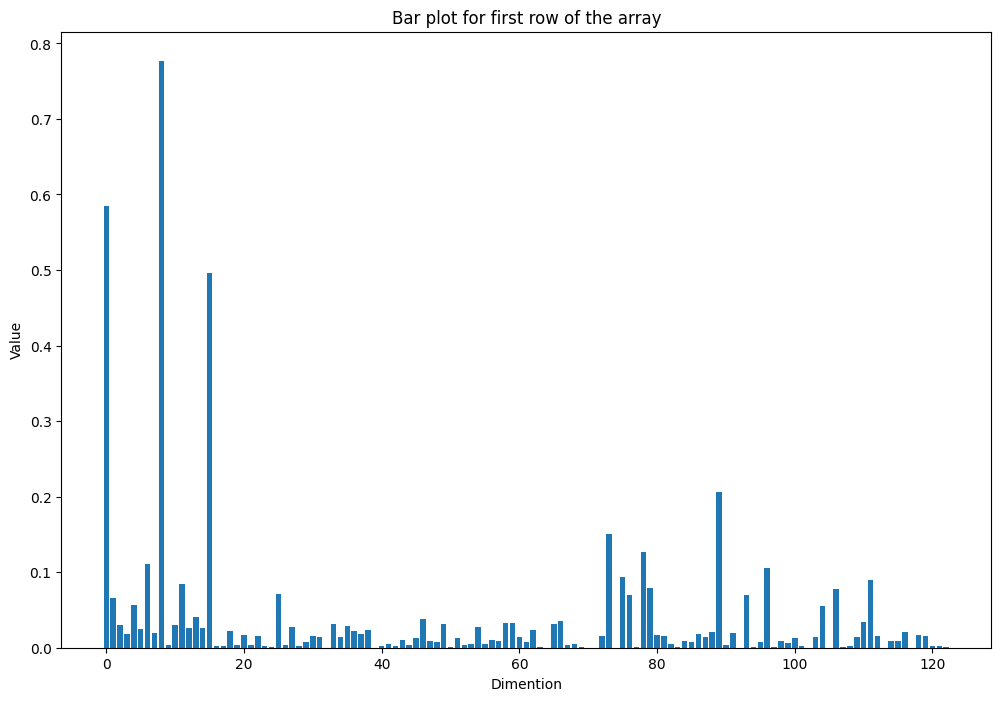

In [ ]:
plt.figure(figsize=(12,8))
plt.bar(range(len(y_val_pred[0])), y_val_pred[0])

plt.xlabel('Dimention')
plt.ylabel('Value')
plt.title('Probabilities Bar plot for first row of the array')
plt.show()

In [135]:
# Since data is not well balanced, we try to improve the F1 Score by deciding were to make the limit to convert to one or cero.
f1_aux = 0
corte_aux = 0
for indice in range(10):
  corte = indice/10
  y_val_pred_bin = [[1 if ele > corte else 0 for ele in fila] for fila in y_val_pred]
  f1_micro = f1_score(y_true=y_val, y_pred=y_val_pred_bin, average='micro')
  if f1_micro > f1_aux:
    f1_aux = f1_micro
    corte_aux = corte

In [136]:
print(corte_aux)

0.3


In [ ]:
y_val_pred_bin = [[1 if ele > corte_aux else 0 for ele in fila] for fila in y_val_pred]
f1_micro = f1_score(y_true=y_val, y_pred=y_val_pred_bin, average='micro')
print(f1_micro)

0.5113884956891005


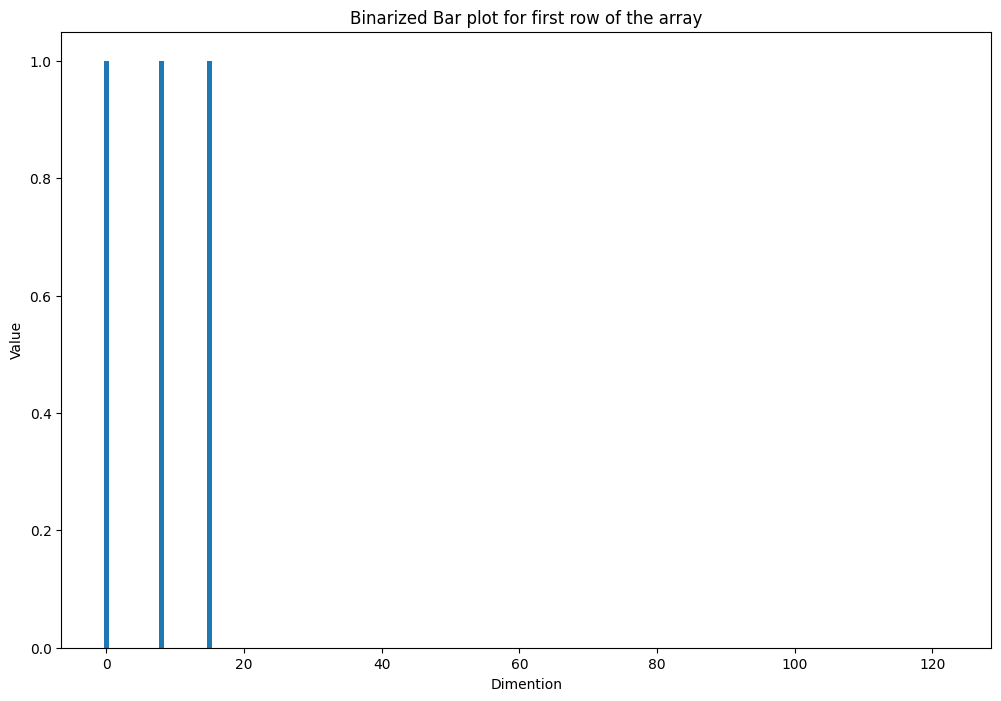

In [ ]:
plt.figure(figsize=(12,8))
plt.bar(range(len(y_val_pred_bin[0])), y_val_pred_bin[0])

plt.xlabel('Dimention')
plt.ylabel('Value')
plt.title('Binarized Bar plot for first row of the array')
plt.show()

In [ ]:
# Finaly we analise the classification report of this model.
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_val, y_val_pred_bin, target_names=y.columns))

                                  precision    recall  f1-score   support

                          others       0.46      0.93      0.62      3178
                       appliance       0.52      0.93      0.67      1444
                      cell phone       0.85      0.90      0.87       987
            cell phone accessory       0.82      0.90      0.86       878
                computer tablets       0.83      0.74      0.79       966
                     video games       0.32      0.95      0.48       868
       connected home housewares       0.56      0.56      0.56       767
        small kitchen appliances       0.00      0.00      0.00       558
               cameras camcorder       0.84      0.80      0.82       529
                           audio       0.59      0.82      0.69       531
                       pre games       0.00      0.00      0.00       636
              musical instrument       0.00      0.00      0.00       424
             car electronics gps     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# We will process the descriptions so as not to confuse the model.
* Remove the words compatible and design as they appear too many times (as seen in the EDA) and can confuse the model.
* We must also eliminate words of a single occurrence since they practically do not affect the model.
* Remove single letter words.

In [ ]:
# We create again the corpus to analise Words Count
corpus = [word for i in products_descri_df['Descriptions'].str.split().values.tolist() for word in i if (word not in stop_words)]

In [ ]:
from nltk.probability import FreqDist
most_common = FreqDist(corpus).most_common(n=None)
most_common_df = pd.DataFrame(most_common, columns=['Word', 'Count'])
most_common_df.head()

,Word,Count
0,compatible,15683
1,design,9636
2,apple,6258
3,control,6093
4,power,5277


In [ ]:
once_df = most_common_df[most_common_df['Count']==1]
len(once_df)

5339

In [ ]:
def elim_words(descripcion):
  '''
  * Remove the words compatible and design as they appear too many times (as seen in the EDA) and can confuse the model.
  * We must also eliminate words of a single occurrence since they practically do not affect the model.
  * Remove single letter words.
  '''
  descri_list = toktok([descripcion])
  descri_list_fin = [word for word in descri_list if word not in once_df['Word'].to_list()][0]
  descri_list_fin = [str(word) for word in descri_list_fin if word not in ['compatible', 'design']]
  descri_list_fin = [str(word) for word in descri_list_fin if word not in stop_words]
  descri_list_fin = [str(word) for word in descri_list_fin if len(str(word))> 1]
  descri_list_concat = ' '.join(descri_list_fin)
  return descri_list_concat

In [ ]:
prod_descri = products_descri_df['Descriptions'].apply(elim_words)
prod_descri[0:10]

0    select electronic device aaa size duralock pow...
1    long last energy duralock power preserve techn...
2    select electronic device aa size duralock powe...
3      pack aa alkaline battery battery tester include
4    select electronic device size duralock power p...
5    select electronic device size duralock power p...
6    select electronic device alkaline chemistry si...
7    expand online assortment directed electronics ...
8                                     alkaline battery
9    expand online assortment ford lincoln mercury ...
Name: Descriptions, dtype: object

# The following is:
* Concatenate prod_descri to dataframe products_descri_df1, which already has y concatenated to it.
* Tokenize the new column.
* Vectorize the new column
* Create new X_train and all others.
* Train a new MLP model with these changes to see if it improves the model and if it gets less confused.

In [ ]:
products_descri_df1['Descriptions_elim'] = prod_descri

In [ ]:
# We tokenize and vectorize the new Descriptions with eliminated words.
products_descri_df1['Descripcions Elim Tokenized'] = toktok(products_descri_df1['Descriptions_elim'], 1, 1)
X_nuevo = vectorizer_pretrained(products_descri_df1['Descripcions Elim Tokenized'], pretrained_w2v_model, 300)
X_nuevo[0:8]

<ipython-input-14-7fda29ee1c8b>:39: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  doc_vector += model.word_vec(word)


array([[-0.14675876,  0.10633511, -0.07035111, ..., -0.2333023 ,
        -0.00273989, -0.10769667],
       [ 0.01810534,  0.08188533, -0.14026858, ..., -0.18234223,
        -0.02546483,  0.02073096],
       [-0.21015267,  0.08889255, -0.10387444, ..., -0.26355785,
        -0.00489196, -0.06211622],
       ...,
       [-0.17645425,  0.0883445 , -0.0610275 , ..., -0.24637261,
        -0.006019  , -0.07587375],
       [-0.22527972,  0.10924723, -0.076431  , ..., -0.27074808,
        -0.04776639, -0.0226856 ],
       [-0.21141393,  0.16576299, -0.02980532, ..., -0.01528007,
        -0.00959288, -0.08001537]], dtype=float32)

In [ ]:
products_descri_df1.head()

,Skus,Descriptions,Char Count,Word Count,Sentence Count,Hashtag Count,@ Count,others,appliance,cell phone,...,security cameras surveillance,build dishwasher,laptop battery,household essential,iphone case,cooktop,coffee maker,Descripcions Tokenized,Descriptions_elim,Descripcions Elim Tokenized
0,43900,compatible select electronic device aaa size d...,95,12,1,0,0,1,0,0,...,0,0,0,0,0,0,0,"[compatible, select, electronic, device, aaa, ...",select electronic device aaa size duralock pow...,"[select, electronic, device, aaa, size, duralo..."
1,48530,long last energy duralock power preserve techn...,112,15,1,0,0,1,0,0,...,0,0,0,0,0,0,0,"[long, last, energy, duralock, power, preserve...",long last energy duralock power preserve techn...,"[long, last, energy, duralock, power, preserve..."
2,127687,compatible select electronic device aa size du...,94,12,1,0,0,1,0,0,...,0,0,0,0,0,0,0,"[compatible, select, electronic, device, aa, s...",select electronic device aa size duralock powe...,"[select, electronic, device, aa, size, duraloc..."
3,150115,pack aa alkaline battery battery tester include,53,7,1,0,0,1,0,0,...,0,0,0,0,0,0,0,"[pack, aa, alkaline, battery, battery, tester,...",pack aa alkaline battery battery tester include,"[pack, aa, alkaline, battery, battery, tester,..."
4,185230,compatible select electronic device c size dur...,93,12,1,0,0,1,0,0,...,0,0,0,0,0,0,0,"[compatible, select, electronic, device, c, si...",select electronic device size duralock power p...,"[select, electronic, device, size, duralock, p..."


In [ ]:
# Split the dataframe into train, test, and validation sets
from sklearn.model_selection import train_test_split

X_train_nuevo, X_inter_nuevo, y_train_nuevo, y_inter_nuevo = train_test_split(X_nuevo, y, test_size=0.3, random_state=42)

X_test_nuevo, X_val_nuevo, y_test_nuevo, y_val_nuevo = train_test_split(X_inter_nuevo, y_inter_nuevo, test_size=0.5, random_state=42)

In [ ]:
y_train_nuevo.head(2)

,others,appliance,cell phone,cell phone accessory,computer tablets,video games,connected home housewares,small kitchen appliances,cameras camcorder,audio,...,nintendo ds games,case,tv,security cameras surveillance,build dishwasher,laptop battery,household essential,iphone case,cooktop,coffee maker
15079,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44478,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print((len(X_train_nuevo), len(y_train_nuevo)))
print((len(X_test_nuevo), len(y_test_nuevo)))
print((len(X_val_nuevo), len(y_val_nuevo)))

(36151, 36151)
(7747, 7747)
(7747, 7747)


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback

input_dim = X_train_nuevo.shape[1]
output_dim = y_train_nuevo.shape[1]
hidden_units = [128, 64, 32]

# We create the MLP model with the specified hidden units per layer indicated in hidden_units.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_units[0], activation='relu', input_dim=input_dim),
    tf.keras.layers.Dense(hidden_units[1], activation='relu'),
    tf.keras.layers.Dense(hidden_units[2], activation='relu'),
    tf.keras.layers.Dense(output_dim, activation='sigmoid')  # We use sigmoid for multilabel classification.
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               38528     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 123)               4059      
                                                                 
Total params: 52,923
Trainable params: 52,923
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# We compile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-2),
              loss='binary_crossentropy',  # Binary Crossentropy for multilabel classification.
              metrics=['accuracy'])

# We use some callbacks to save the best model and reduce learning rate on plateau.
checkpoint_callback = ModelCheckpoint(filepath='modelos/descri_mlp_elim.h5', monitor='val_accuracy', save_best_only=True)

reduce_lr_callback = ReduceLROnPlateau(monitor='loss', factor=0.15, patience=3)

# Finally we fit the model.
model.fit(X_train_nuevo, y_train_nuevo, validation_data=(X_test_nuevo, y_test_nuevo), epochs=50, batch_size=32, callbacks=[checkpoint_callback, reduce_lr_callback])

Epoch 1/50
1130/1130 [==============================] - 8s 5ms/step - loss: 0.0743 - accuracy: 0.5358 - val_loss: 0.0627 - val_accuracy: 0.5627 - lr: 0.0500
Epoch 2/50
1130/1130 [==============================] - 6s 5ms/step - loss: 0.0653 - accuracy: 0.5451 - val_loss: 0.0654 - val_accuracy: 0.5779 - lr: 0.0500
Epoch 3/50
1130/1130 [==============================] - 5s 4ms/step - loss: 0.0668 - accuracy: 0.5628 - val_loss: 0.0672 - val_accuracy: 0.5509 - lr: 0.0500
Epoch 4/50
1130/1130 [==============================] - 7s 6ms/step - loss: 0.0655 - accuracy: 0.5624 - val_loss: 0.0720 - val_accuracy: 0.5376 - lr: 0.0500
Epoch 5/50
1130/1130 [==============================] - 5s 4ms/step - loss: 0.0678 - accuracy: 0.5538 - val_loss: 0.0694 - val_accuracy: 0.5705 - lr: 0.0500
Epoch 6/50
1130/1130 [==============================] - 5s 4ms/step - loss: 0.0627 - accuracy: 0.5732 - val_loss: 0.0631 - val_accuracy: 0.5672 - lr: 0.0075
Epoch 7/50
1130/1130 [==============================] - 6s

In [ ]:
y_val_pred_nuevo = model.predict(X_val_nuevo)

print(y_val_pred_nuevo)

243/243 [==============================] - 0s 2ms/step
[[3.2080764e-01 3.7276551e-10 9.6610402e-06 ... 7.6569433e-32
  1.5989965e-10 3.9115566e-34]
 [5.0593197e-01 9.8431039e-01 1.6608929e-04 ... 2.5184119e-10
  4.2841179e-04 1.0777619e-01]
 [6.2524879e-01 4.0072951e-04 3.9203485e-05 ... 1.1149055e-09
  1.6090858e-06 9.1557338e-11]
 ...
 [6.0357159e-01 7.6043516e-01 3.0177501e-03 ... 1.3216063e-09
  1.7384607e-02 3.0351388e-03]
 [3.2328466e-01 9.9332958e-01 1.3690181e-09 ... 3.9061477e-17
  8.5123553e-09 1.9106252e-02]
 [1.5246208e-02 4.6540382e-37 1.0633707e-29 ... 0.0000000e+00
  2.0265925e-38 0.0000000e+00]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

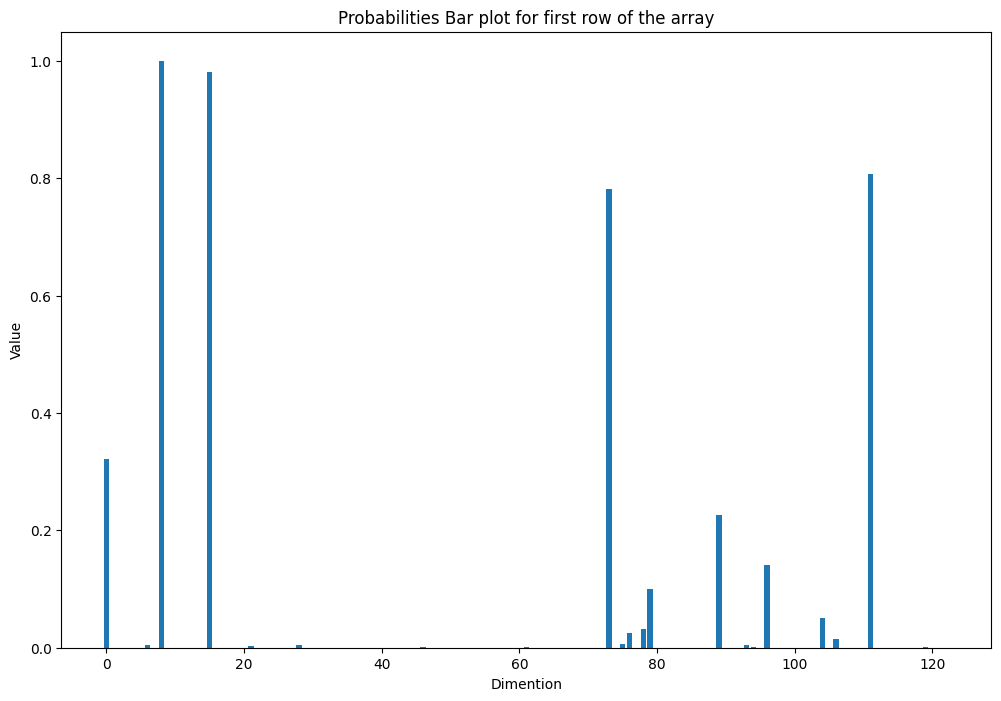

In [ ]:
plt.figure(figsize=(12,8))
plt.bar(range(len(y_val_pred_nuevo[0])), y_val_pred_nuevo[0])

plt.xlabel('Dimention')
plt.ylabel('Value')
plt.title('Probabilities Bar plot for first row of the array')
plt.show()

In [138]:
# Since data is not well balanced, we try to improve the F1 Score by deciding were to make the limit to convert to one or cero.
f1_aux = 0
corte_aux = 0
for indice in range(10):
  corte = indice/10
  y_val_pred_nuevo_bin = [[1 if ele > corte else 0 for ele in fila] for fila in y_val_pred_nuevo]
  f1_micro = f1_score(y_true=y_val, y_pred=y_val_pred_nuevo_bin, average='micro')
  if f1_micro > f1_aux:
    f1_aux = f1_micro
    corte_aux = corte

In [139]:
print(corte_aux)

0.3


In [ ]:
y_val_pred_nuevo_bin = [[1 if ele > corte_aux else 0 for ele in fila] for fila in y_val_pred_nuevo]
f1_micro = f1_score(y_true=y_val, y_pred=y_val_pred_nuevo_bin, average='micro')
print(f1_micro)

0.6292590922137029


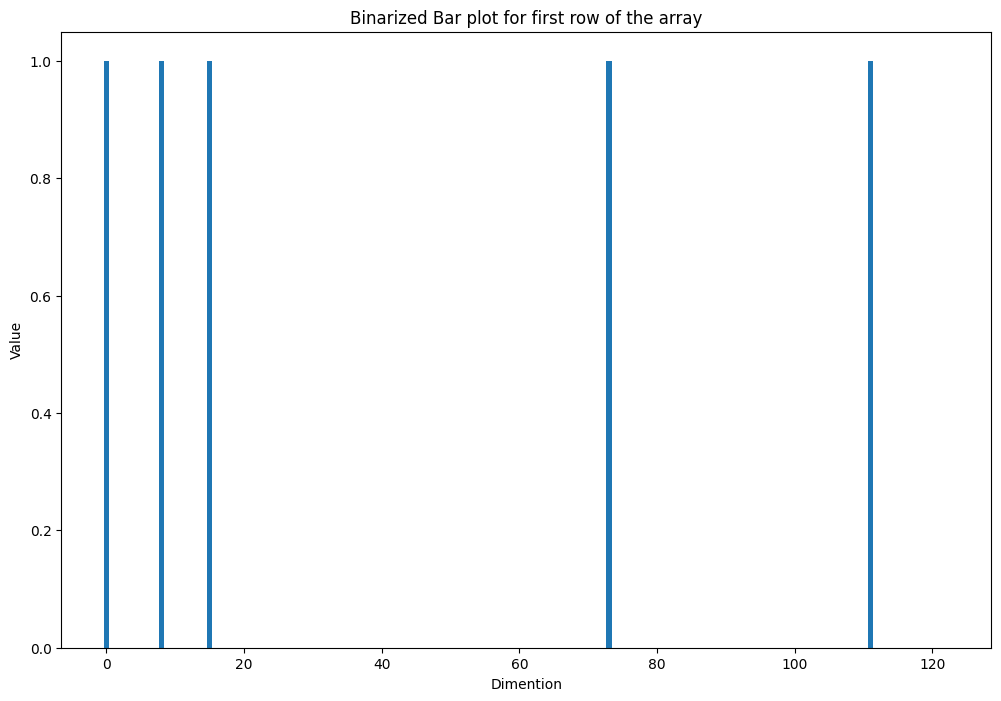

In [ ]:
plt.figure(figsize=(12,8))
plt.bar(range(len(y_val_pred_nuevo_bin[0])), y_val_pred_nuevo_bin[0])

plt.xlabel('Dimention')
plt.ylabel('Value')
plt.title('Binarized Bar plot for first row of the array')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val_nuevo, y_val_pred_nuevo_bin, target_names=y.columns))

                                  precision    recall  f1-score   support

                          others       0.52      0.92      0.67      3178
                       appliance       0.91      0.93      0.92      1444
                      cell phone       0.85      0.95      0.90       987
            cell phone accessory       0.78      0.94      0.86       878
                computer tablets       0.71      0.86      0.78       966
                     video games       0.96      0.91      0.94       868
       connected home housewares       0.67      0.65      0.66       767
        small kitchen appliances       0.79      0.82      0.81       558
               cameras camcorder       0.93      0.83      0.88       529
                           audio       0.69      0.85      0.76       531
                       pre games       0.72      0.81      0.76       636
              musical instrument       0.61      0.64      0.63       424
             car electronics gps     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# The next model to test is an LSTM encoder together with an MLP for multi-label classification.

In [ ]:
products_descri_df1.head(3)

,Skus,Descriptions,Char Count,Word Count,Sentence Count,Hashtag Count,@ Count,others,appliance,cell phone,...,security cameras surveillance,build dishwasher,laptop battery,household essential,iphone case,cooktop,coffee maker,Descripcions Tokenized,Descriptions_elim,Descripcions Elim Tokenized
0,43900,compatible select electronic device aaa size d...,95,12,1,0,0,1,0,0,...,0,0,0,0,0,0,0,"[compatible, select, electronic, device, aaa, ...",select electronic device aaa size duralock pow...,"[select, electronic, device, aaa, size, duralo..."
1,48530,long last energy duralock power preserve techn...,112,15,1,0,0,1,0,0,...,0,0,0,0,0,0,0,"[long, last, energy, duralock, power, preserve...",long last energy duralock power preserve techn...,"[long, last, energy, duralock, power, preserve..."
2,127687,compatible select electronic device aa size du...,94,12,1,0,0,1,0,0,...,0,0,0,0,0,0,0,"[compatible, select, electronic, device, aa, s...",select electronic device aa size duralock powe...,"[select, electronic, device, aa, size, duraloc..."


In [ ]:
# We eliminate the columns that wont be necesary anymore.
products_descri_df2 = products_descri_df1.drop(['Descriptions', 'Char Count', 'Word Count', 'Sentence Count', 'Hashtag Count', '@ Count'], axis=1)
products_descri_df2.head(3)

,Skus,others,appliance,cell phone,cell phone accessory,computer tablets,video games,connected home housewares,small kitchen appliances,cameras camcorder,...,security cameras surveillance,build dishwasher,laptop battery,household essential,iphone case,cooktop,coffee maker,Descripcions Tokenized,Descriptions_elim,Descripcions Elim Tokenized
0,43900,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,"[compatible, select, electronic, device, aaa, ...",select electronic device aaa size duralock pow...,"[select, electronic, device, aaa, size, duralo..."
1,48530,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,"[long, last, energy, duralock, power, preserve...",long last energy duralock power preserve techn...,"[long, last, energy, duralock, power, preserve..."
2,127687,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,"[compatible, select, electronic, device, aa, s...",select electronic device aa size duralock powe...,"[select, electronic, device, aa, size, duraloc..."


In [ ]:
# We tokenize the descriptions and calculate how many words are ther per row.
products_descri_df2['Descripcions Elim Tokenized'] = toktok(products_descri_df2['Descriptions_elim'], 1, 1)
products_descri_df2['Word Count'] = products_descri_df2['Descripcions Elim Tokenized'].apply(len)
products_descri_df2

,Skus,others,appliance,cell phone,cell phone accessory,computer tablets,video games,connected home housewares,small kitchen appliances,cameras camcorder,...,build dishwasher,laptop battery,household essential,iphone case,cooktop,coffee maker,Descripcions Tokenized,Descriptions_elim,Descripcions Elim Tokenized,Word Count
0,43900,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,"[compatible, select, electronic, device, aaa, ...",select electronic device aaa size duralock pow...,"[select, electronic, device, aaa, size, duralo...",10
1,48530,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,"[long, last, energy, duralock, power, preserve...",long last energy duralock power preserve techn...,"[long, last, energy, duralock, power, preserve...",13
2,127687,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,"[compatible, select, electronic, device, aa, s...",select electronic device aa size duralock powe...,"[select, electronic, device, aa, size, duraloc...",10
3,150115,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,"[pack, aa, alkaline, battery, battery, tester,...",pack aa alkaline battery battery tester include,"[pack, aa, alkaline, battery, battery, tester,...",7
4,185230,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,"[compatible, select, electronic, device, c, si...",select electronic device size duralock power p...,"[select, electronic, device, size, duralock, p...",9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51640,9995663,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,"[compatible, select, honeywell, air, purifier,...",select honeywell air purifier model capture mi...,"[select, honeywell, air, purifier, model, capt...",12
51641,9996238,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,"[remove, dirt, grime, hard, floor, cloth, mate...",remove dirt grime hard floor cloth material wipe,"[remove, dirt, grime, hard, floor, cloth, mate...",8
51642,9996826,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,"[x, total, bay, x, bay]",total bay bay,"[total, bay, bay]",3
51643,9999119,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,"[stream, p, content, dual, band, dual, antenna...",stream content dual band dual antenna wi fi mi...,"[stream, content, dual, band, dual, antenna, w...",24


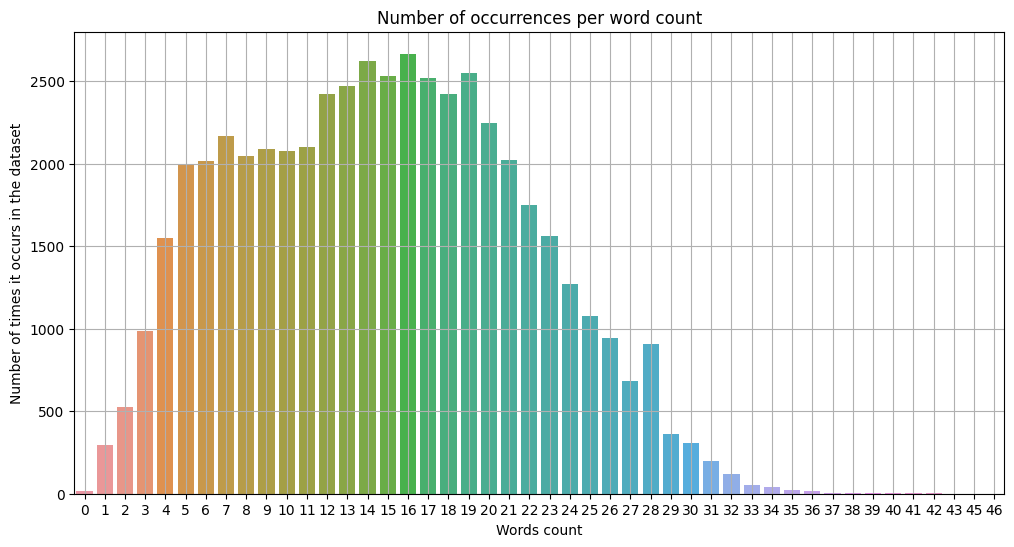

In [ ]:
# We plot the count of the amount of words per row.
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
ax = sns.countplot(data=products_descri_df2, x='Word Count')

plt.xlabel('Words count')
plt.ylabel('Number of times it occurs in the dataset')
plt.title('Number of occurrences per word count')
plt.grid(True)

plt.show()

## We will truncate the number of words to 35 words and we will eliminate the examples with very short descriptions since they would provide little context information for a correct classification.

In [ ]:
#Remove examples with descriptions of less than 4 words

In [ ]:
products_descri_df2 = products_descri_df2[products_descri_df2['Word Count'] >= 5]
products_descri_df2

,Skus,others,appliance,cell phone,cell phone accessory,computer tablets,video games,connected home housewares,small kitchen appliances,cameras camcorder,...,build dishwasher,laptop battery,household essential,iphone case,cooktop,coffee maker,Descripcions Tokenized,Descriptions_elim,Descripcions Elim Tokenized,Word Count
0,43900,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,"[compatible, select, electronic, device, aaa, ...",select electronic device aaa size duralock pow...,"[select, electronic, device, aaa, size, duralo...",10
1,48530,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,"[long, last, energy, duralock, power, preserve...",long last energy duralock power preserve techn...,"[long, last, energy, duralock, power, preserve...",13
2,127687,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,"[compatible, select, electronic, device, aa, s...",select electronic device aa size duralock powe...,"[select, electronic, device, aa, size, duraloc...",10
3,150115,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,"[pack, aa, alkaline, battery, battery, tester,...",pack aa alkaline battery battery tester include,"[pack, aa, alkaline, battery, battery, tester,...",7
4,185230,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,"[compatible, select, electronic, device, c, si...",select electronic device size duralock power p...,"[select, electronic, device, size, duralock, p...",9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51639,9993674,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,"[compatible, select, vicks, sunbeam, honeywell...",select vicks sunbeam honeywell humidifier mode...,"[select, vicks, sunbeam, honeywell, humidifier...",11
51640,9995663,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,"[compatible, select, honeywell, air, purifier,...",select honeywell air purifier model capture mi...,"[select, honeywell, air, purifier, model, capt...",12
51641,9996238,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,"[remove, dirt, grime, hard, floor, cloth, mate...",remove dirt grime hard floor cloth material wipe,"[remove, dirt, grime, hard, floor, cloth, mate...",8
51643,9999119,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,"[stream, p, content, dual, band, dual, antenna...",stream content dual band dual antenna wi fi mi...,"[stream, content, dual, band, dual, antenna, w...",24


In [ ]:
# Now we truncate the number of words to 35 words.

In [ ]:
def trunc_palabras(lista_palabras):
  lista_return = []
  len_lista = len(lista_palabras)
  for i in range(35):
    if i < len_lista:
      lista_return.append(lista_palabras[i])
  return lista_return

In [ ]:
products_descri_df2['Descripcions Elim Tokenized Truncated'] = products_descri_df2['Descripcions Elim Tokenized'].apply(trunc_palabras)
products_descri_df2.head(3)

<ipython-input-98-ffcaf81a80bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_descri_df2['Descripcions Elim Tokenized Truncated'] = products_descri_df2['Descripcions Elim Tokenized'].apply(trunc_palabras)


,Skus,others,appliance,cell phone,cell phone accessory,computer tablets,video games,connected home housewares,small kitchen appliances,cameras camcorder,...,laptop battery,household essential,iphone case,cooktop,coffee maker,Descripcions Tokenized,Descriptions_elim,Descripcions Elim Tokenized,Word Count,Descripcions Elim Tokenized Truncated
0,43900,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,"[compatible, select, electronic, device, aaa, ...",select electronic device aaa size duralock pow...,"[select, electronic, device, aaa, size, duralo...",10,"[select, electronic, device, aaa, size, duralo..."
1,48530,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,"[long, last, energy, duralock, power, preserve...",long last energy duralock power preserve techn...,"[long, last, energy, duralock, power, preserve...",13,"[long, last, energy, duralock, power, preserve..."
2,127687,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,"[compatible, select, electronic, device, aa, s...",select electronic device aa size duralock powe...,"[select, electronic, device, aa, size, duraloc...",10,"[select, electronic, device, aa, size, duraloc..."


In [ ]:
# We count the words again to see how the distribution is after having tricked them.
products_descri_df2['Word Count Truncated'] = products_descri_df2['Descripcions Elim Tokenized Truncated'].apply(len)
products_descri_df2.head(3)

<ipython-input-100-1185d3e69a3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_descri_df2['Word Count Truncated'] = products_descri_df2['Descripcions Elim Tokenized Truncated'].apply(len)


,Skus,others,appliance,cell phone,cell phone accessory,computer tablets,video games,connected home housewares,small kitchen appliances,cameras camcorder,...,household essential,iphone case,cooktop,coffee maker,Descripcions Tokenized,Descriptions_elim,Descripcions Elim Tokenized,Word Count,Descripcions Elim Tokenized Truncated,Word Count Truncated
0,43900,1,0,0,0,0,0,1,0,0,...,0,0,0,0,"[compatible, select, electronic, device, aaa, ...",select electronic device aaa size duralock pow...,"[select, electronic, device, aaa, size, duralo...",10,"[select, electronic, device, aaa, size, duralo...",10
1,48530,1,0,0,0,0,0,1,0,0,...,0,0,0,0,"[long, last, energy, duralock, power, preserve...",long last energy duralock power preserve techn...,"[long, last, energy, duralock, power, preserve...",13,"[long, last, energy, duralock, power, preserve...",13
2,127687,1,0,0,0,0,0,1,0,0,...,0,0,0,0,"[compatible, select, electronic, device, aa, s...",select electronic device aa size duralock powe...,"[select, electronic, device, aa, size, duraloc...",10,"[select, electronic, device, aa, size, duraloc...",10


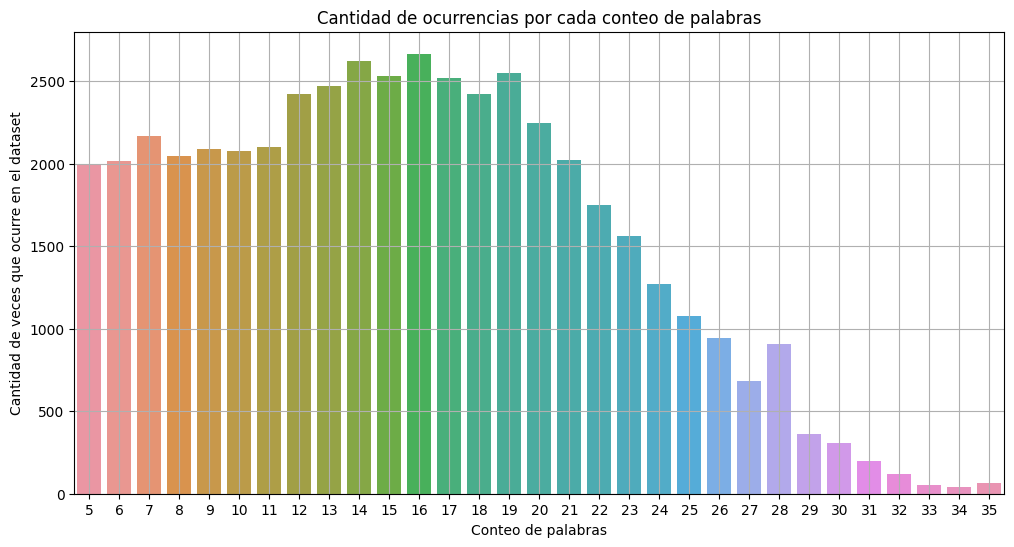

In [ ]:
# We see again the count of words distribution.
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
ax = sns.countplot(data=products_descri_df2, x='Word Count Truncated')

plt.xlabel('Conteo de palabras')
plt.ylabel('Cantidad de veces que ocurre en el dataset')
plt.title('Cantidad de ocurrencias por cada conteo de palabras')
plt.grid(True)

plt.show()

In [ ]:
# Just to see an example of words in a row.
products_descri_df2['Descripcions Elim Tokenized Truncated'][0]

['select',
 'electronic',
 'device',
 'aaa',
 'size',
 'duralock',
 'power',
 'preserve',
 'technology',
 'pack']

In [ ]:
import tensorflow as tf

In [ ]:
# We create a new X to train a new model with the changes made before.
X_lstm_mlp = products_descri_df2['Descripcions Elim Tokenized Truncated']
X_lstm_mlp.head()

0    [select, electronic, device, aaa, size, duralo...
1    [long, last, energy, duralock, power, preserve...
2    [select, electronic, device, aa, size, duraloc...
3    [pack, aa, alkaline, battery, battery, tester,...
4    [select, electronic, device, size, duralock, p...
Name: Descripcions Elim Tokenized Truncated, dtype: object

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
# We tokenize in this way since it is easier to have a word to number convertion.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_lstm_mlp)

In [ ]:
# Convert words to numeric index
X_sequences = tokenizer.texts_to_sequences(X_lstm_mlp)
X_sequences[0:2]

[[10, 67, 26, 1945, 115, 3448, 3, 2107, 9, 118],
 [539, 1376, 312, 3448, 3, 2107, 9, 2258, 793, 138, 463, 117, 5405]]

In [ ]:
# We define the paddin that has to be used as maximun amount of words.
max_sequence_length = 35

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Padding implementation
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post')

In [ ]:
# To see a couple of examples of the padding result.
X_padded[0:2]

array([[  10,   67,   26, 1945,  115, 3448,    3, 2107,    9,  118,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [ 539, 1376,  312, 3448,    3, 2107,    9, 2258,  793,  138,  463,
         117, 5405,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]], dtype=int32)

In [ ]:
# We create a new y to train the model eliminating the unnecesary colums.
y_lstm_mlp = products_descri_df2.drop(['Skus', 'Descripcions Tokenized', 'Descriptions_elim',	'Descripcions Elim Tokenized',	'Word Count',	'Descripcions Elim Tokenized Truncated',	'Word Count Truncated'], axis=1)
y_lstm_mlp

,others,appliance,cell phone,cell phone accessory,computer tablets,video games,connected home housewares,small kitchen appliances,cameras camcorder,audio,...,nintendo ds games,case,tv,security cameras surveillance,build dishwasher,laptop battery,household essential,iphone case,cooktop,coffee maker
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51639,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51640,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
51641,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51643,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Split the dataframe into train, test, and validation sets
from sklearn.model_selection import train_test_split

X_train_lstm_mlp, X_inter_lstm_mlp, y_train_lstm_mlp, y_inter_lstm_mlp = train_test_split(X_padded, y_lstm_mlp, test_size=0.3, random_state=42)

X_test_lstm_mlp, X_val_lstm_mlp, y_test_lstm_mlp, y_val_lstm_mlp = train_test_split(X_inter_lstm_mlp, y_inter_lstm_mlp, test_size=0.5, random_state=42)

print((len(X_train_lstm_mlp), len(y_train_lstm_mlp)))
print((len(X_test_lstm_mlp), len(y_test_lstm_mlp)))
print((len(X_val_lstm_mlp), len(y_val_lstm_mlp)))

(33793, 33793)
(7242, 7242)
(7242, 7242)


In [ ]:
# Here we define some hiperparameters for the model.
embedding_dim = 150
lstm_units = 40
num_classes = len(y_lstm_mlp.columns)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

17777

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate

# Define the input
input_text = Input(shape=(max_sequence_length,))

# Define the embedding layer
embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size,            # Vocabulary size (amount of unique words)
    output_dim=embedding_dim,        # Embedings dimention.
    trainable=True                   # Allow the embedings to be trainable during the fitting.
)(input_text)

In [ ]:
# Define the LSTM layers and obtain the final states.
lstm_layers = []
all_states_h = []
all_states_c = []

for _ in range(lstm_units):
    lstm, state_h, state_c = tf.keras.layers.LSTM(lstm_units, return_state=True)(embedding_layer)
    lstm_layers.append(lstm)
    all_states_h.append(state_h)
    all_states_c.append(state_c)

# Concatenate the hidden states.
concatenated_h = tf.concat(all_states_h, axis=-1)
concatenated_c = tf.concat(all_states_c, axis=-1)

In [ ]:
# Define the MLP input with the concatenated hidden states as inputs.
mlp_input = tf.concat([concatenated_h, concatenated_c], axis=-1)

In [ ]:
# Define the MLP structure.
hidden_units = [1024, 512, 256, 128, 64, 32]  # Number of hidden units in each hidden layer.

mlp_layer = mlp_input
for units in hidden_units:
    mlp_layer = tf.keras.layers.Dense(units, activation='relu')(mlp_layer)

output = tf.keras.layers.Dense(num_classes, activation='sigmoid')(mlp_layer)

# Define the complete model.
model_lstm_mlp = tf.keras.Model(inputs=input_text, outputs=output)

In [ ]:
# Compile the model.
model_lstm_mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3),
              loss='binary_crossentropy',  # Binary Crossentropy for multilabel classifier.
              metrics=['accuracy'])

model_lstm_mlp.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 150)      2666550     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40),         30560       ['embedding[0][0]']              
                                 (None, 40),                                                      
                                 (None, 40)]                                                      
                                                                                              

In [ ]:
# Callbacks implementation.
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback

checkpoint_callback = ModelCheckpoint(filepath='modelos/descri_lstm_mlp.h5', monitor='val_accuracy', save_best_only=True)

reduce_lr_callback = ReduceLROnPlateau(monitor='loss', factor=0.10, patience=2)

In [ ]:
# Finally we fit the model.
model_lstm_mlp.fit(X_train_lstm_mlp,
                   y_train_lstm_mlp,
                   validation_data=(X_test_lstm_mlp, y_test_lstm_mlp),
                   epochs=50,
                   batch_size=24,
                   callbacks=[checkpoint_callback, reduce_lr_callback])

Epoch 1/50
1409/1409 [==============================] - 257s 126ms/step - loss: 0.0969 - accuracy: 0.4525 - val_loss: 0.0759 - val_accuracy: 0.5619 - lr: 0.0050
Epoch 2/50
1409/1409 [==============================] - 135s 95ms/step - loss: 0.0630 - accuracy: 0.5727 - val_loss: 0.0549 - val_accuracy: 0.5526 - lr: 0.0050
Epoch 3/50
1409/1409 [==============================] - 136s 96ms/step - loss: 0.0457 - accuracy: 0.6144 - val_loss: 0.0424 - val_accuracy: 0.6299 - lr: 0.0050
Epoch 4/50
1409/1409 [==============================] - 135s 96ms/step - loss: 0.0384 - accuracy: 0.6269 - val_loss: 0.0397 - val_accuracy: 0.6159 - lr: 0.0050
Epoch 5/50
1409/1409 [==============================] - 133s 94ms/step - loss: 0.0345 - accuracy: 0.6352 - val_loss: 0.0381 - val_accuracy: 0.6183 - lr: 0.0050
Epoch 6/50
1409/1409 [==============================] - 135s 96ms/step - loss: 0.0320 - accuracy: 0.6504 - val_loss: 0.0398 - val_accuracy: 0.6477 - lr: 0.0050
Epoch 7/50
1409/1409 [=================

In [ ]:
from tensorflow.keras.models import load_model

# Charge the trained model
descri_lstm_mlp = load_model('modelos/descri_lstm_mlp.h5')

# Summary of the model.
descri_lstm_mlp.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 150)      2666550     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40),         30560       ['embedding[0][0]']              
                                 (None, 40),                                                      
                                 (None, 40)]                                                      
                                                                                              

In [ ]:
y_val_pred_lstm_mlp = descri_lstm_mlp.predict(X_val_lstm_mlp)

print(y_val_pred_lstm_mlp)

227/227 [==============================] - 24s 36ms/step
[[2.5820032e-01 3.6172345e-04 1.4145818e-08 ... 7.1370916e-11
  9.4984520e-05 1.5367613e-07]
 [6.4598346e-01 2.4899296e-06 2.5212469e-03 ... 1.7047519e-06
  2.7217129e-10 2.1998516e-10]
 [9.4485492e-02 3.8989219e-05 9.8726302e-01 ... 7.3707742e-03
  3.5044486e-06 1.3424402e-07]
 ...
 [8.3496213e-01 9.2064040e-03 7.0212875e-03 ... 1.8557797e-05
  8.7780488e-04 3.4833050e-04]
 [8.6689657e-01 2.4577547e-03 2.7134934e-02 ... 1.0117024e-05
  1.6677786e-05 2.0260059e-05]
 [7.3653698e-02 1.4546137e-08 7.1866838e-05 ... 4.8467771e-11
  3.6037530e-13 9.7401376e-14]]


In [ ]:
len(y_val_pred_lstm_mlp[0])

123

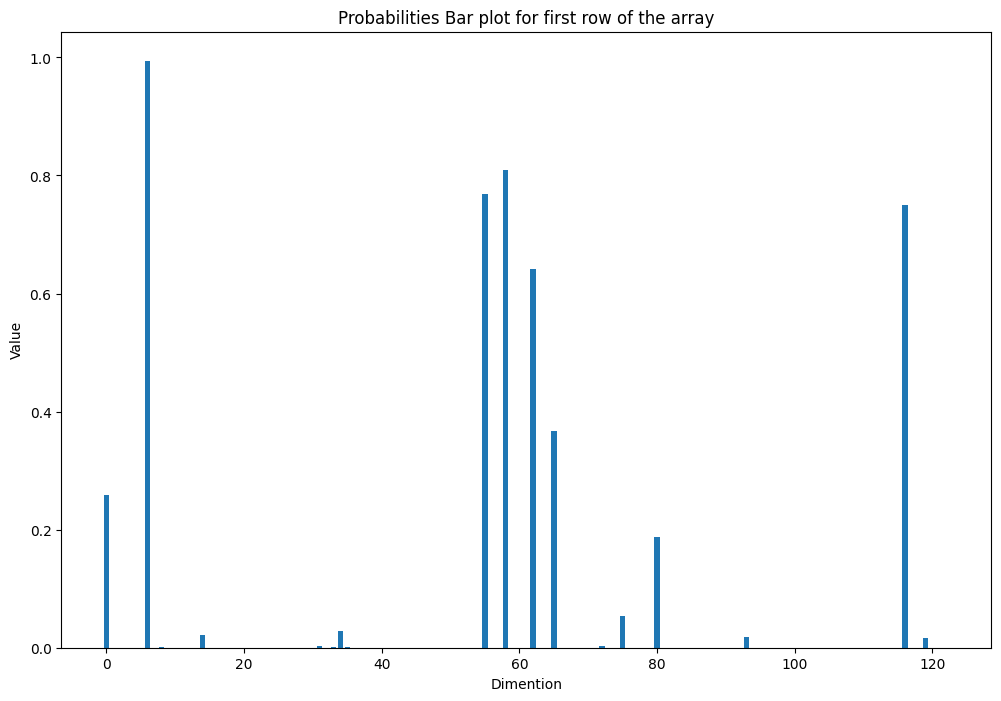

In [ ]:
plt.figure(figsize=(12,8))
plt.bar(range(len(y_val_pred_lstm_mlp[0])), y_val_pred_lstm_mlp[0])

plt.xlabel('Dimention')
plt.ylabel('Value')
plt.title('Probabilities Bar plot for first row of the array')
plt.show()

In [140]:
# Since data is not well balanced, we try to improve the F1 Score by deciding were to make the limit to convert to one or cero.
f1_aux = 0
corte_aux = 0
for indice in range(10):
  corte = indice/10
  y_val_pred_lstm_mlp_bin = [[1 if ele > corte else 0 for ele in fila] for fila in y_val_pred_lstm_mlp]
  f1_micro = f1_score(y_true=y_val_lstm_mlp, y_pred=y_val_pred_lstm_mlp_bin, average='micro')
  if f1_micro > f1_aux:
    f1_aux = f1_micro
    corte_aux = corte

In [141]:
print(corte_aux)

0.4


In [ ]:
y_val_pred_lstm_mlp_bin = [[1 if ele > corte_aux else 0 for ele in fila] for fila in y_val_pred_lstm_mlp]
f1_micro = f1_score(y_true=y_val_lstm_mlp, y_pred=y_val_pred_lstm_mlp_bin, average='micro')
print(f1_micro)

0.7307321350284962


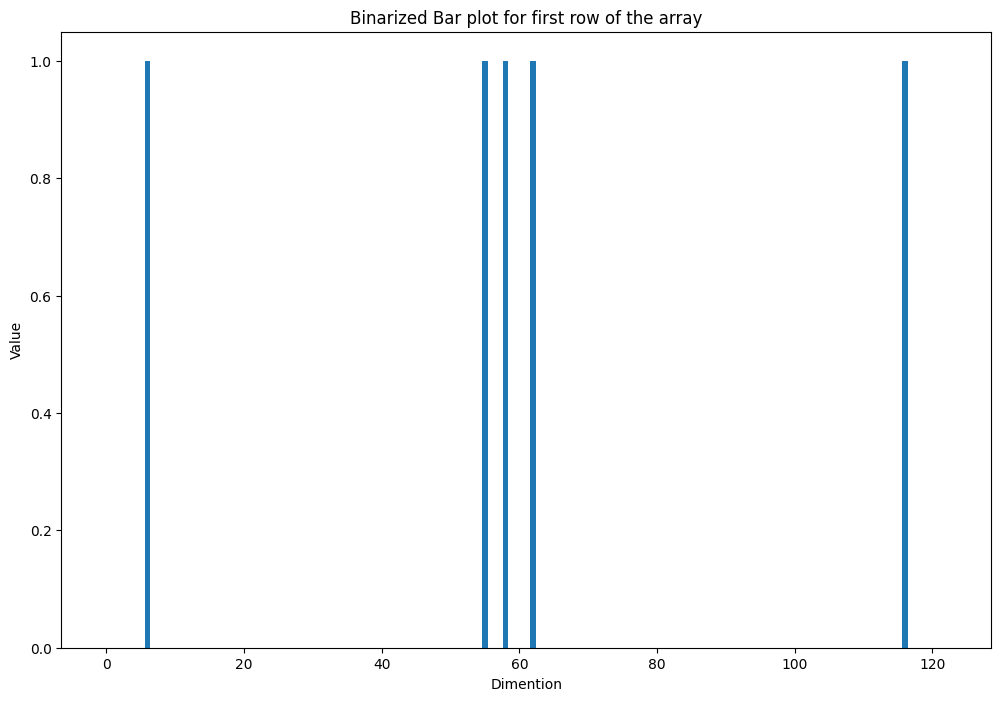

In [ ]:
plt.figure(figsize=(12,8))
plt.bar(range(len(y_val_pred_lstm_mlp_bin[0])), y_val_pred_lstm_mlp_bin[0])

plt.xlabel('Dimention')
plt.ylabel('Value')
plt.title('Binarized Bar plot for first row of the array')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val_lstm_mlp, y_val_pred_lstm_mlp_bin, target_names=y.columns))

                                  precision    recall  f1-score   support

                          others       0.64      0.90      0.75      3048
                       appliance       0.96      0.96      0.96      1362
                      cell phone       0.94      0.94      0.94       970
            cell phone accessory       0.94      0.93      0.93       869
                computer tablets       0.94      0.80      0.86       864
                     video games       0.96      0.90      0.93       640
       connected home housewares       0.90      0.83      0.86       710
        small kitchen appliances       0.93      0.88      0.91       528
               cameras camcorder       0.96      0.90      0.93       553
                           audio       0.87      0.88      0.87       537
                       pre games       0.70      0.79      0.75       462
              musical instrument       0.68      0.86      0.76       456
             car electronics gps     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
